<a href="https://colab.research.google.com/github/Parvez-Mondol/fashion-cnn-210114/blob/main/CNN_210114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Clone your repo (replace with your actual URL)
!git clone https://github.com/Parvez-Mondol/fashion-cnn-210114.git
%cd fashion-cnn-210114

Cloning into 'fashion-cnn-210114'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 25.74 KiB | 6.43 MiB/s, done.
/content/fashion-cnn-210114


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

In [4]:
# Standard transforms for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # FashionMNIST mean/std for grayscale
])

# Same transform for custom images
transform_custom = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 41.0MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 61.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.0MB/s]


In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Standard transforms for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # FashionMNIST mean/std for grayscale
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation on test set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(test_loader))
    val_accs.append(val_acc)

    print(f'''Epoch {epoch+1}/{num_epochs},
          Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%,
          Val Loss: {val_loss/len(test_loader):.4f}, Acc: {val_acc:.2f}%''')

# Save model
os.makedirs('model', exist_ok=True)
torch.save(model.state_dict(), 'model/190110.pth')

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.85MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.3MB/s]


Epoch 1/10,
          Train Loss: 0.5362, Acc: 80.97%,
          Val Loss: 0.3344, Acc: 87.80%
Epoch 2/10,
          Train Loss: 0.3434, Acc: 87.60%,
          Val Loss: 0.2791, Acc: 89.98%
Epoch 3/10,
          Train Loss: 0.2893, Acc: 89.75%,
          Val Loss: 0.2627, Acc: 90.32%
Epoch 4/10,
          Train Loss: 0.2581, Acc: 90.81%,
          Val Loss: 0.2467, Acc: 91.04%
Epoch 5/10,
          Train Loss: 0.2384, Acc: 91.37%,
          Val Loss: 0.2339, Acc: 91.59%
Epoch 6/10,
          Train Loss: 0.2191, Acc: 91.99%,
          Val Loss: 0.2282, Acc: 91.79%
Epoch 7/10,
          Train Loss: 0.2013, Acc: 92.68%,
          Val Loss: 0.2242, Acc: 92.19%
Epoch 8/10,
          Train Loss: 0.1861, Acc: 93.14%,
          Val Loss: 0.2375, Acc: 91.95%
Epoch 9/10,
          Train Loss: 0.1744, Acc: 93.55%,
          Val Loss: 0.2271, Acc: 92.27%
Epoch 10/10,
          Train Loss: 0.1650, Acc: 93.80%,
          Val Loss: 0.2384, Acc: 91.81%


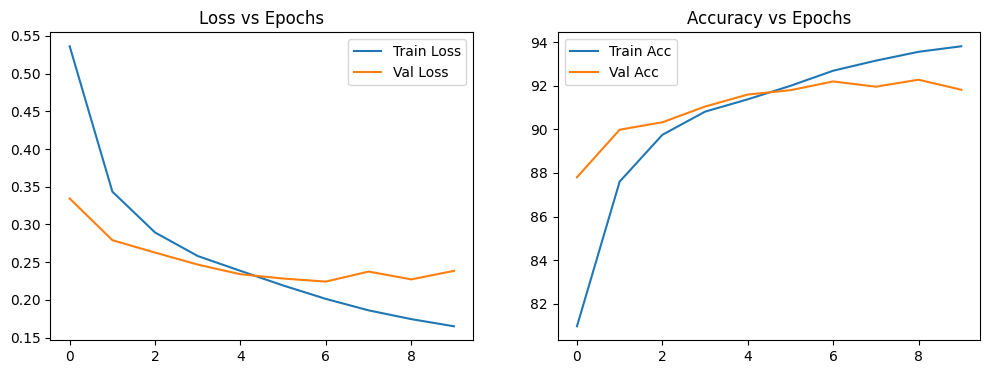

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

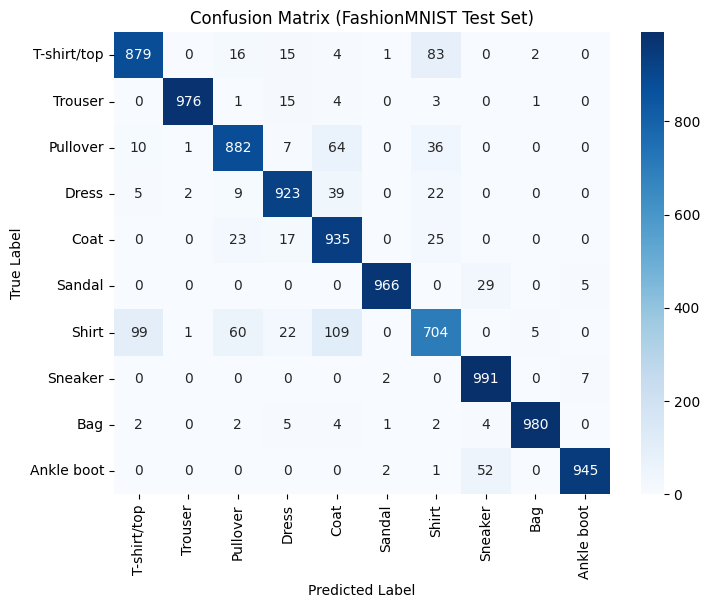

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix (FashionMNIST Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

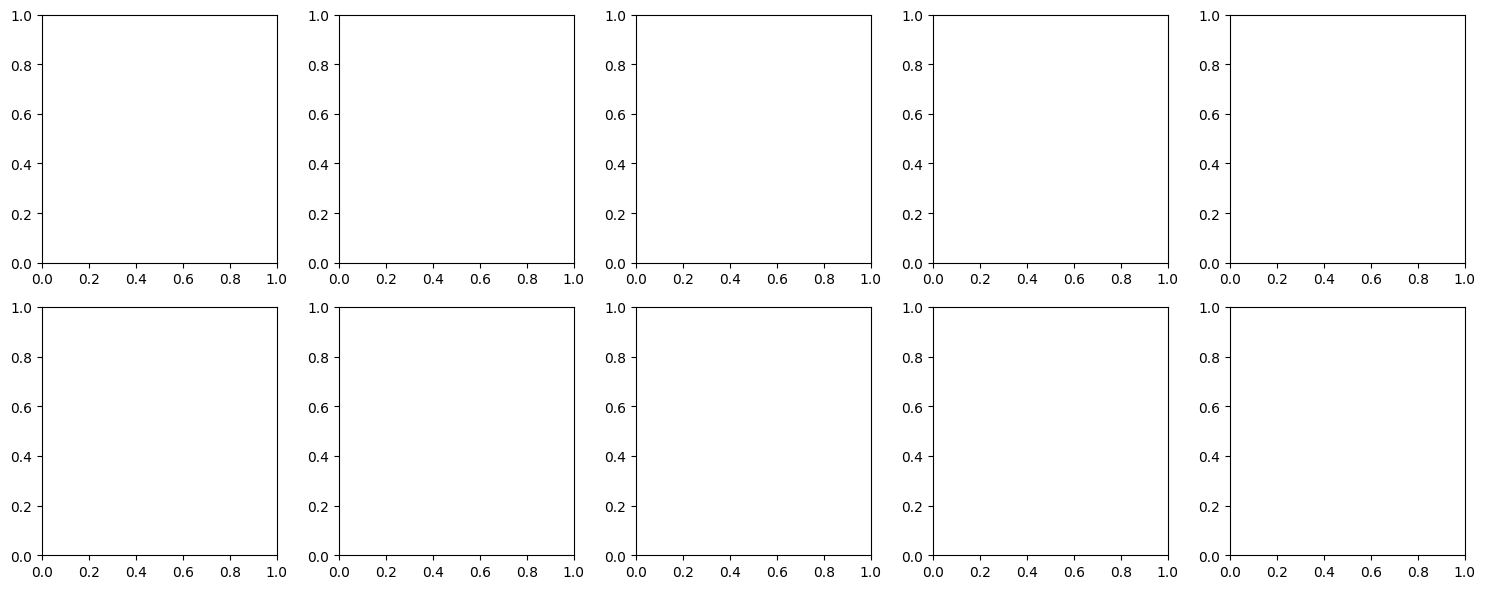

In [11]:
# Get list of custom images
custom_img_dir = 'dataset/'
os.makedirs(custom_img_dir, exist_ok=True)
custom_images = [f for f in os.listdir(custom_img_dir) if f.endswith(('.jpg', '.png'))]
custom_images.sort()

# Class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load model in eval mode
model.load_state_dict(torch.load('model/190110.pth', map_location=device))
model.eval()

# Predictions gallery
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, img_name in enumerate(custom_images[:10]):
    img_path = os.path.join(custom_img_dir, img_name)
    image = Image.open(img_path).convert('L')  # Grayscale
    input_tensor = transform_custom(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)

    pred_class = classes[predicted.item()]
    conf = confidence.item() * 100

    # Show image
    axes[idx].imshow(image, cmap='gray')
    axes[idx].set_title(f'Pred: {pred_class}\n({conf:.1f}%)', fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

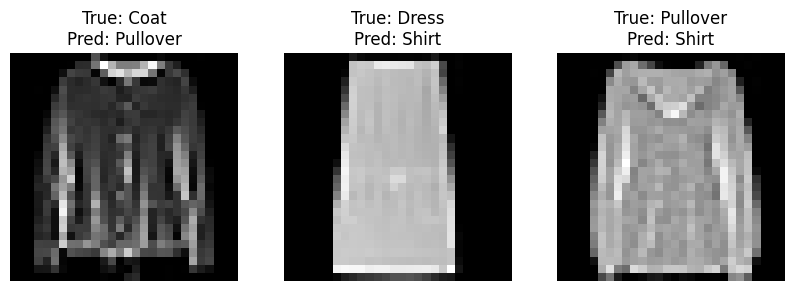

In [12]:
model.eval()
wrong_images = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i] and len(wrong_images) < 3:
                wrong_images.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, (img, true, pred) in enumerate(wrong_images):
    img = img.squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {classes[true]}\nPred: {classes[pred]}')
    axes[i].axis('off')
plt.show()

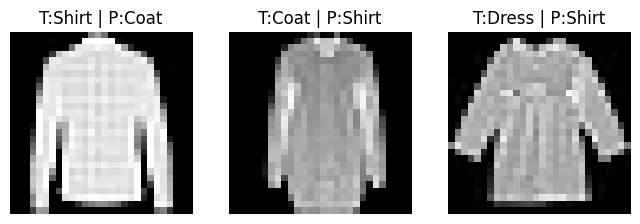

In [14]:
import numpy as np
import matplotlib.pyplot as plt

wrong = [(i, all_preds[i], all_labels[i])
         for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

sample = np.random.choice(len(wrong), 3, replace=False)

plt.figure(figsize=(8,4))
for idx, s in enumerate(sample):
    i, pred, true = wrong[s]
    img, _ = test_dataset[i]
    plt.subplot(1,3,idx+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T:{classes[true]} | P:{classes[pred]}")
    plt.axis("off")
plt.show()